In [2]:
from unet import UNet
from utils.config import load_config
from utils.metrics import dice_score
from theoretical_receptive_field import compute_trf
from matplotlib import pyplot as plt
from IPython.display import Image, display
from torch.utils.data import DataLoader
from train import SegmentationDataset
import matplotlib.patches as patches
import numpy as np
import torch
import glob
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Theoretical Receptive Field
### 1.1. Default configuration (i.e. baseline)

In [3]:
cfg_default = load_config("default")
model_default = UNet(cfg_default).to(device)
rf_default = model_default.output_trfs()
n_params_default = model_default.total_parameters()

#### 1.1.1. (Max) TRF size of each layer

In [3]:
_ = compute_trf(model_default, 576, print_output=True)

-----------------------------------------------
UNet wit configuration:     default
Total number of parameters: 31730497
layer  type             max_trf_size skip conn.
    0  input layer                 1           

EncoderBlock
    1  Conv2d                      3           
    2  BatchNorm2d                 3           
    3  ReLU                        3           
    4  Conv2d                      5           
    5  BatchNorm2d                 5           
    6  ReLU                        5      1 OUT
    7  MaxPool2d                   6           

EncoderBlock
    8  Conv2d                     10           
    9  BatchNorm2d                10           
   10  ReLU                       10           
   11  Conv2d                     14           
   12  BatchNorm2d                14           
   13  ReLU                       14      2 OUT
   14  MaxPool2d                  16           

EncoderBlock
   15  Conv2d                     24           
   16  BatchNorm2d   

#### 1.1.2. Heatmap of TRF size for each pixel in the image
Value is the square root of the area of the pixel's TRF.

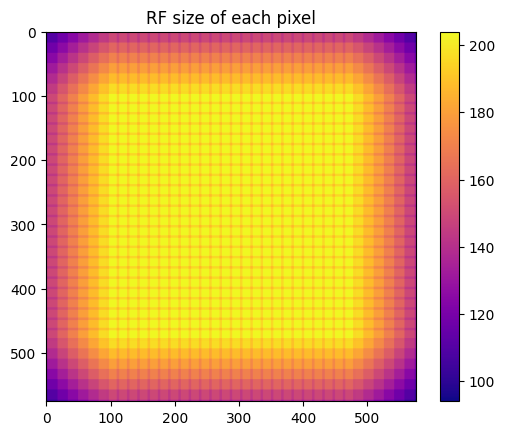

In [4]:
a = rf_default[:, :, 1, 1] - rf_default[:, :, 0, 1] + 1
b = rf_default[:, :, 1, 0] - rf_default[:, :, 0, 0] + 1
rf_sizes = np.sqrt(np.multiply(a, b))
plt.imshow(rf_sizes, cmap="plasma")
plt.colorbar()
plt.title("RF size of each pixel")
plt.show()

#### 1.1.3. Some TRFs of specific pixels

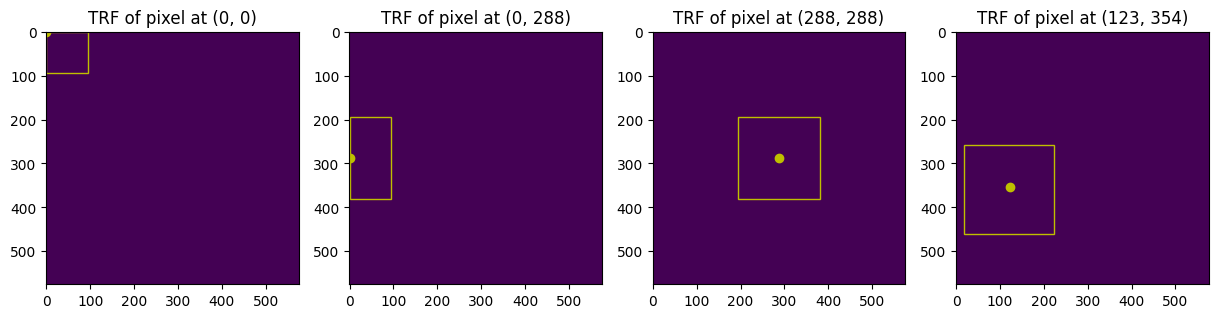

In [5]:
topleft_trf = model_default.pixel_trf(0, 0), (0,0)
topcenter_trf = model_default.pixel_trf(0, 576//2), (0, 576//2)
center_trf = model_default.pixel_trf(576//2, 576//2), (576//2, 576//2)
other_trf = model_default.pixel_trf(123, 354), (123, 354)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i, (trf, pos) in enumerate([topleft_trf, topcenter_trf, center_trf, other_trf]):
    axs[i].imshow(np.zeros((576, 576)))
    axs[i].plot(pos[0], pos[1], 'yo')
    axs[i].set_title(f"TRF of pixel at {pos}")
    start = trf[0, 0], trf[0, 1]
    len_x = trf[1, 0] - trf[0, 0] + 1
    len_y = trf[1, 1] - trf[0, 1] + 1
    patch = patches.Rectangle(start, len_x, len_y, linewidth=1, edgecolor='y', facecolor='none')
    axs[i].add_patch(patch)

plt.show()

#### 1.1.4. Training results
These are the loss plots of the two training sets when training for 100 epochs.
I found experimentally that a batch size of 2 and starting learning rate of 0.01 are optimal for both datasets.

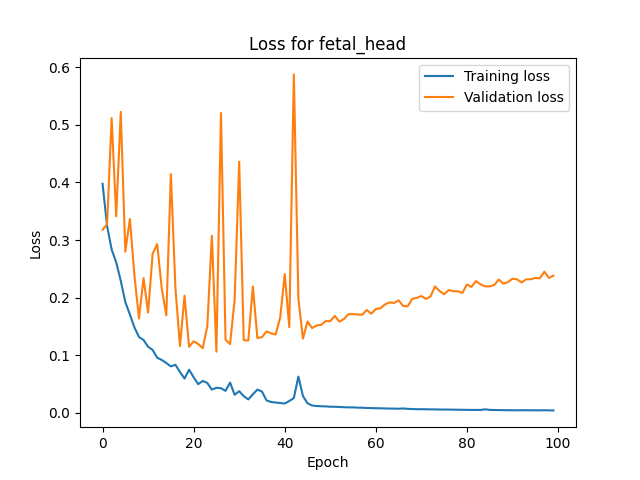

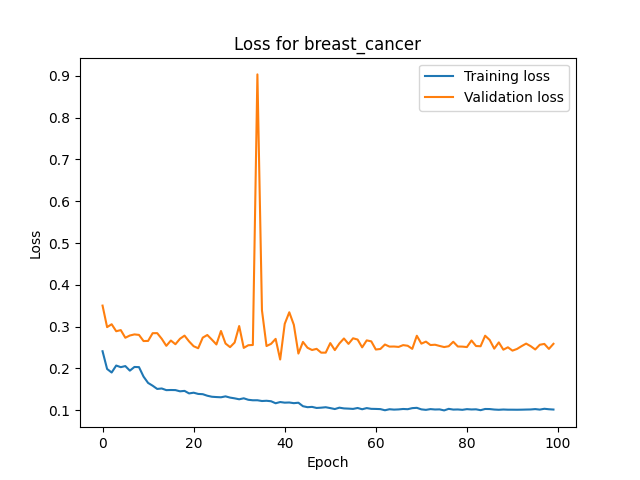

In [6]:
display(Image(filename='results/default/fetal_head.png'))
display(Image(filename='results/default/breast_cancer.png'))

#### 1.1.5. Test results
Lets look at the dice scores on the test sets and inspect some examples.

Average test dice score for fetal_head: 0.96
Average test dice score for breast_cancer: 0.39


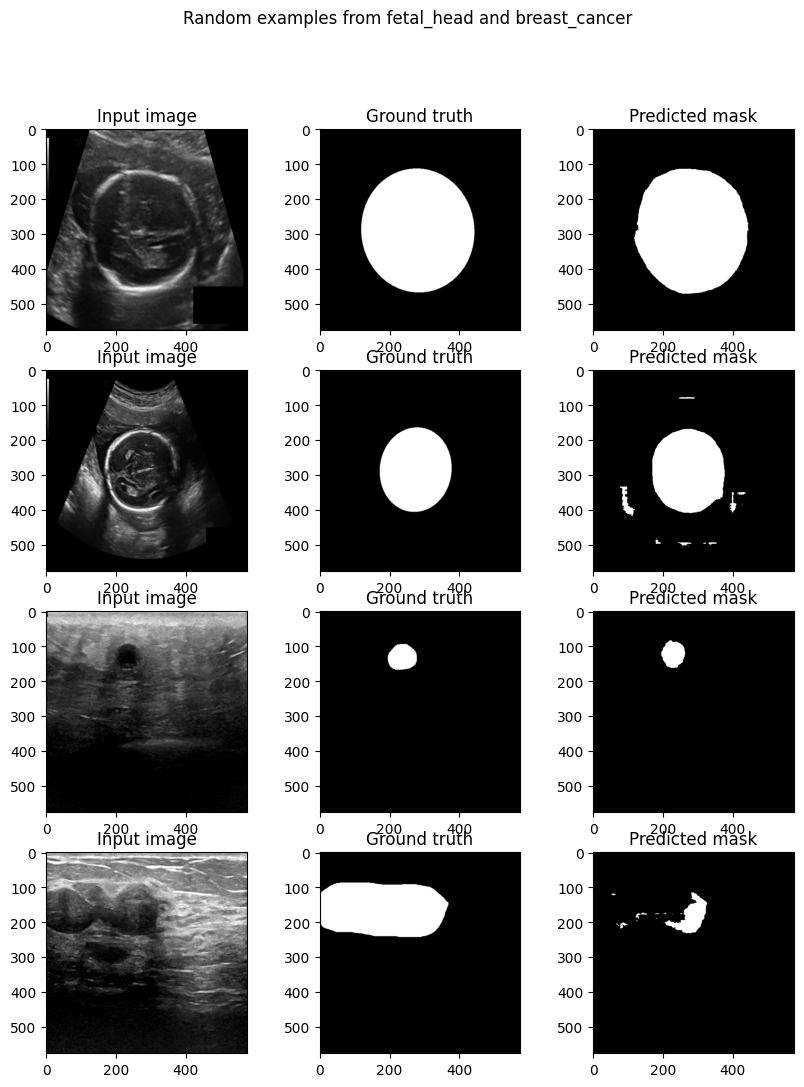

In [10]:
fig, axs = plt.subplots(4, 3, figsize=(10, 12))

for n, dataset_name in enumerate(["fetal_head", "breast_cancer"]):
    model_default.load_state_dict(torch.load(f"results/default/{dataset_name}_best_model.pt")["model_state_dict"])
    model_default.eval()

    inputs_test = glob.glob(os.path.join(f"data/preprocessed/{dataset_name}/test", "*.png"))
    masks_test = glob.glob(os.path.join(f"data/preprocessed/{dataset_name}/test/masks", "*.png"))

    dataset_test = SegmentationDataset(inputs_test, masks_test)
    dataloader_test = DataLoader(dataset_test, shuffle=True)

    scores = []

    for i, (x, y) in enumerate(dataloader_test):
        x = x.to(device)
        y_true = y.to(device) / 255
        out = torch.sigmoid(model_default(x))
        out = out.detach().cpu().numpy()
        out = (out >= 0.5).astype(int)
        out = np.squeeze(out)

        score = dice_score(out, np.squeeze(y.numpy()))
        scores.append(score)

        if i < 2:
            if n == 0:
                axs[2*n+i, 0].set_title("Input image")
                axs[2*n+i, 1].set_title("Ground truth")
                axs[2*n+i, 2].set_title("Predicted mask")
            axs[2*n+i, 0].imshow(np.squeeze(x.cpu().numpy()), cmap="gray")
            axs[2*n+i, 1].imshow(np.squeeze(y.numpy()), cmap="gray")
            axs[2*n+i, 2].imshow(out, cmap="gray")
    
    print(f"Average test dice score for {dataset_name}: {np.mean(scores):.2f}")
plt.suptitle(f"Random examples from fetal_head and breast_cancer")
plt.show()

### 1.2. Large TRF (by increasing depth)
For this configuration I have increased the depth of the network from 4 to 5 (i.e. 5 encoder and 5 decoder blocks), and tuned the channel sizes such that it has approximately the same number of parameters as the baseline model.

In [32]:
cfg_large_rf_by_depth = load_config("large_rf_by_depth")
model_large_rf_by_depth = UNet(cfg_large_rf_by_depth).to(device)
rf_large_rf_by_depth = model_large_rf_by_depth.output_trfs()
n_params_large_rf_by_depth = model_large_rf_by_depth.total_parameters()

param_ratio = n_params_large_rf_by_depth/n_params_default*100
print(f"{param_ratio:.4f}% of the parameters of the baseline model")

99.9954% of the parameters of the baseline model


#### 1.2.1. (Max) TRF size of each layer

In [33]:
_ = compute_trf(model_large_rf_by_depth, 576, print_output=True)

-----------------------------------------------
UNet wit configuration:     large_rf
Total number of parameters: 31729053
layer  type             max_trf_size skip conn.
    0  input layer                 1           

EncoderBlock
    1  Conv2d                      3           
    2  BatchNorm2d                 3           
    3  ReLU                        3           
    4  Conv2d                      5           
    5  BatchNorm2d                 5           
    6  ReLU                        5      1 OUT
    7  MaxPool2d                   6           

EncoderBlock
    8  Conv2d                     10           
    9  BatchNorm2d                10           
   10  ReLU                       10           
   11  Conv2d                     14           
   12  BatchNorm2d                14           
   13  ReLU                       14      2 OUT
   14  MaxPool2d                  16           

EncoderBlock
   15  Conv2d                     24           
   16  BatchNorm2d  

#### 1.2.2. Heatmap of TRF size for each pixel in the image
Value is the square root of the area of the pixel's TRF.

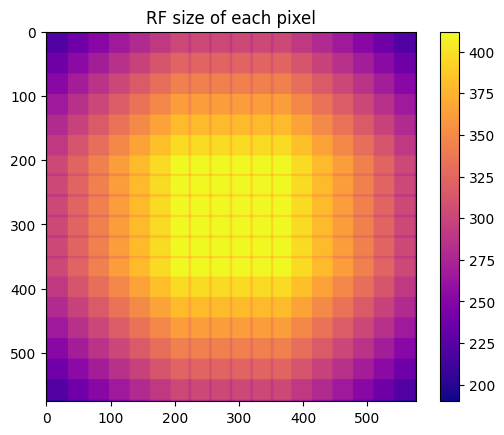

In [34]:
a = rf_large_rf_by_depth[:, :, 1, 1] - rf_large_rf_by_depth[:, :, 0, 1] + 1
b = rf_large_rf_by_depth[:, :, 1, 0] - rf_large_rf_by_depth[:, :, 0, 0] + 1
rf_sizes = np.sqrt(np.multiply(a, b))
plt.imshow(rf_sizes, cmap="plasma")
plt.colorbar()
plt.title("RF size of each pixel")
plt.show()

#### 1.2.3. Some TRFs of specific pixels

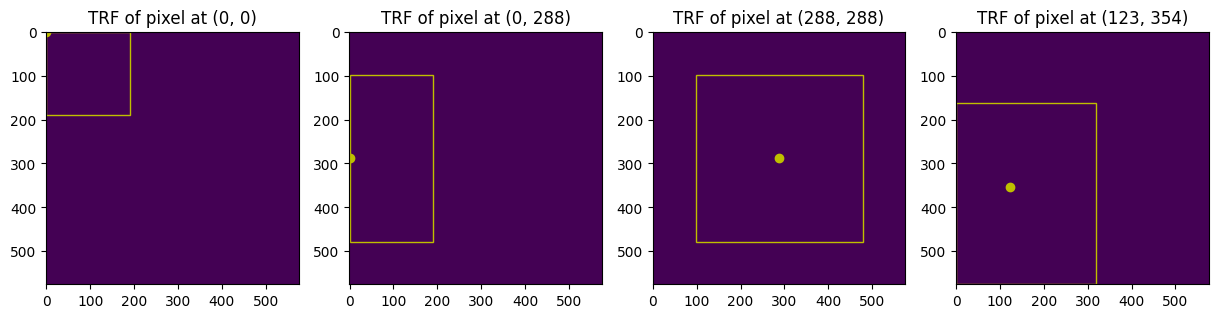

In [36]:
topleft_trf = model_large_rf_by_depth.pixel_trf(0, 0), (0,0)
topcenter_trf = model_large_rf_by_depth.pixel_trf(0, 576//2), (0, 576//2)
center_trf = model_large_rf_by_depth.pixel_trf(576//2, 576//2), (576//2, 576//2)
other_trf = model_large_rf_by_depth.pixel_trf(123, 354), (123, 354)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i, (trf, pos) in enumerate([topleft_trf, topcenter_trf, center_trf, other_trf]):
    axs[i].imshow(np.zeros((576, 576)))
    axs[i].plot(pos[0], pos[1], 'yo')
    axs[i].set_title(f"TRF of pixel at {pos}")
    start = trf[0, 0], trf[0, 1]
    len_x = trf[1, 0] - trf[0, 0] + 1
    len_y = trf[1, 1] - trf[0, 1] + 1
    patch = patches.Rectangle(start, len_x, len_y, linewidth=1, edgecolor='y', facecolor='none')
    axs[i].add_patch(patch)

plt.show()

#### 1.2.4. Training results
These are the loss plots of the two training sets when training for 100 epochs.
I found experimentally that a batch size of 2 and starting learning rate of 0.01 are optimal for both datasets.

In [ ]:
display(Image(filename='results/large_rf_by_depth/fetal_head.png'))
display(Image(filename='results/large_rf_by_depth/breast_cancer.png'))

#### 1.2.5. Test results

In [ ]:
# TODO

## 1.3. Large TRF (by tuning hyperparameters)
Increased convolution kernel from 3 to 4, changed channel sizes to keep same number of parameters.

In [41]:
cfg_large_rf_by_hparams = load_config("large_rf_by_hparams")
model_large_rf_by_hparams = UNet(cfg_large_rf_by_hparams).to(device)
rf_large_rf_by_hparams = model_large_rf_by_hparams.output_trfs()
n_params_large_rf_by_hparams = model_large_rf_by_hparams.total_parameters()

param_ratio = n_params_large_rf_by_hparams/n_params_default*100
print(f"{param_ratio:.4f}% of the parameters of the baseline model")

100.0120% of the parameters of the baseline model


#### 1.3.1. (Max) TRF size of each layer

In [42]:
_ = compute_trf(model_large_rf_by_hparams, 576, print_output=True)

-----------------------------------------------
UNet wit configuration:     large_rf_by_hparams
Total number of parameters: 31734319
layer  type             max_trf_size skip conn.
    0  input layer                 1           

EncoderBlock
    1  Conv2d                      4           
    2  BatchNorm2d                 4           
    3  ReLU                        4           
    4  Conv2d                      7           
    5  BatchNorm2d                 7           
    6  ReLU                        7      1 OUT
    7  MaxPool2d                   8           

EncoderBlock
    8  Conv2d                     14           
    9  BatchNorm2d                14           
   10  ReLU                       14           
   11  Conv2d                     20           
   12  BatchNorm2d                20           
   13  ReLU                       20      2 OUT
   14  MaxPool2d                  22           

EncoderBlock
   15  Conv2d                     34           
   16  Ba

#### 1.3.2. Heatmap of TRF size for each pixel in the image
Value is the square root of the area of the pixel's TRF.

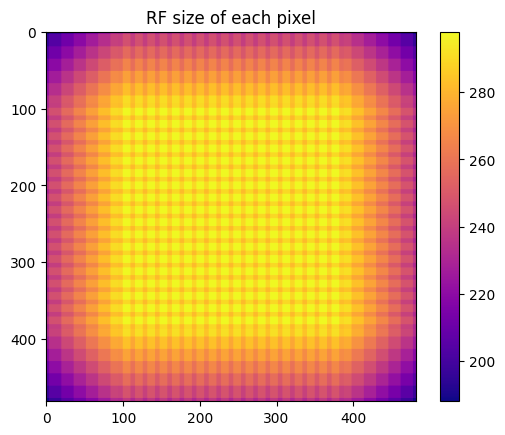

In [43]:
a = rf_large_rf_by_hparams[:, :, 1, 1] - rf_large_rf_by_hparams[:, :, 0, 1] + 1
b = rf_large_rf_by_hparams[:, :, 1, 0] - rf_large_rf_by_hparams[:, :, 0, 0] + 1
rf_sizes = np.sqrt(np.multiply(a, b))
plt.imshow(rf_sizes, cmap="plasma")
plt.colorbar()
plt.title("RF size of each pixel")
plt.show()

#### 1.3.3. Some TRFs of specific pixels

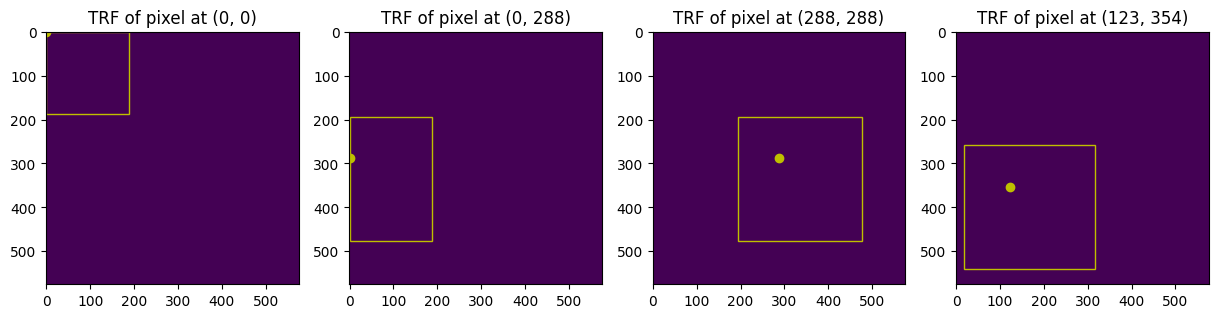

In [44]:
topleft_trf = model_large_rf_by_hparams.pixel_trf(0, 0), (0,0)
topcenter_trf = model_large_rf_by_hparams.pixel_trf(0, 576//2), (0, 576//2)
center_trf = model_large_rf_by_hparams.pixel_trf(576//2, 576//2), (576//2, 576//2)
other_trf = model_large_rf_by_hparams.pixel_trf(123, 354), (123, 354)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i, (trf, pos) in enumerate([topleft_trf, topcenter_trf, center_trf, other_trf]):
    axs[i].imshow(np.zeros((576, 576)))
    axs[i].plot(pos[0], pos[1], 'yo')
    axs[i].set_title(f"TRF of pixel at {pos}")
    start = trf[0, 0], trf[0, 1]
    len_x = trf[1, 0] - trf[0, 0] + 1
    len_y = trf[1, 1] - trf[0, 1] + 1
    patch = patches.Rectangle(start, len_x, len_y, linewidth=1, edgecolor='y', facecolor='none')
    axs[i].add_patch(patch)

plt.show()

#### 1.3.4. Training results
These are the loss plots of the two training sets when training for 100 epochs.
I found experimentally that a batch size of 2 and starting learning rate of 0.01 are optimal for both datasets.

In [ ]:
display(Image(filename='results/large_rf_by_hparams/fetal_head.png'))
display(Image(filename='results/large_rf_by_hparams/breast_cancer.png'))

#### 1.3.5. Test results

In [ ]:
# TODO

## 1.4. Small TRF (by decreasing depth)
For this configuration I have increased the depth of the network from 4 to 3 (i.e. 3 encoder and 3 decoder blocks), and tuned the channel sizes such that it has approximately the same number of parameters as the baseline model.

In [6]:
cfg_small_rf_by_depth = load_config("small_rf_by_depth")
model_small_rf_by_depth = UNet(cfg_small_rf_by_depth).to(device)
rf_small_rf_by_depth = model_small_rf_by_depth.output_trfs()
n_params_small_rf_by_depth = model_small_rf_by_depth.total_parameters()

param_ratio = n_params_small_rf_by_depth/n_params_default*100
print(f"{param_ratio:.4f}% of the parameters of the baseline model")

99.9978% of the parameters of the baseline model


#### 1.4.1. (Max) TRF size of each layer

In [7]:
_ = compute_trf(model_small_rf_by_depth, 576, print_output=True)

-----------------------------------------------
UNet wit configuration:     small_rf_by_depth
Total number of parameters: 31729805
layer  type             max_trf_size skip conn.
    0  input layer                 1           

EncoderBlock
    1  Conv2d                      3           
    2  BatchNorm2d                 3           
    3  ReLU                        3           
    4  Conv2d                      5           
    5  BatchNorm2d                 5           
    6  ReLU                        5      1 OUT
    7  MaxPool2d                   6           

EncoderBlock
    8  Conv2d                     10           
    9  BatchNorm2d                10           
   10  ReLU                       10           
   11  Conv2d                     14           
   12  BatchNorm2d                14           
   13  ReLU                       14      2 OUT
   14  MaxPool2d                  16           

EncoderBlock
   15  Conv2d                     24           
   16  Batc

#### 1.4.2. Heatmap of TRF size for each pixel in the image
Value is the square root of the area of the pixel's TRF.

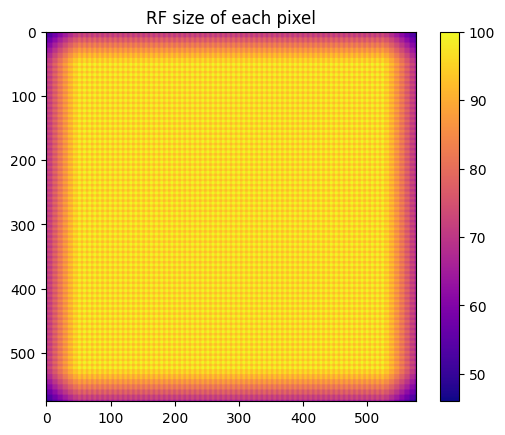

In [8]:
a = rf_small_rf_by_depth[:, :, 1, 1] - rf_small_rf_by_depth[:, :, 0, 1] + 1
b = rf_small_rf_by_depth[:, :, 1, 0] - rf_small_rf_by_depth[:, :, 0, 0] + 1
rf_sizes = np.sqrt(np.multiply(a, b))
plt.imshow(rf_sizes, cmap="plasma")
plt.colorbar()
plt.title("RF size of each pixel")
plt.show()

#### 1.4.3. Some TRFs of specific pixels

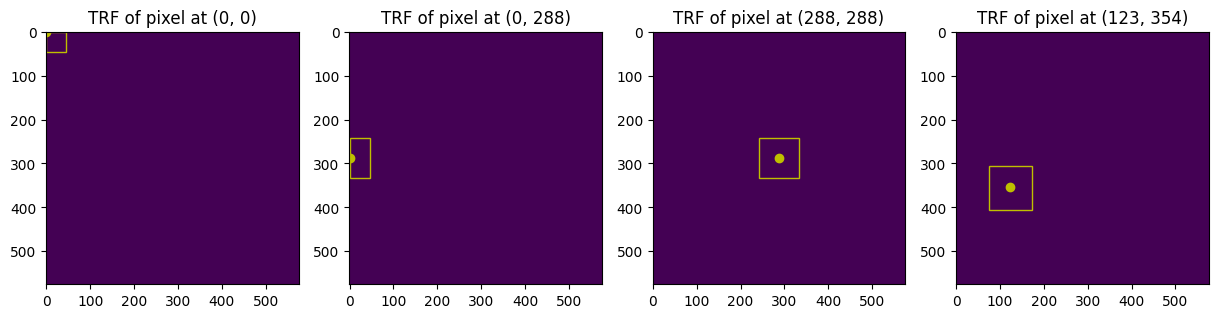

In [9]:
topleft_trf = model_small_rf_by_depth.pixel_trf(0, 0), (0,0)
topcenter_trf = model_small_rf_by_depth.pixel_trf(0, 576//2), (0, 576//2)
center_trf = model_small_rf_by_depth.pixel_trf(576//2, 576//2), (576//2, 576//2)
other_trf = model_small_rf_by_depth.pixel_trf(123, 354), (123, 354)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i, (trf, pos) in enumerate([topleft_trf, topcenter_trf, center_trf, other_trf]):
    axs[i].imshow(np.zeros((576, 576)))
    axs[i].plot(pos[0], pos[1], 'yo')
    axs[i].set_title(f"TRF of pixel at {pos}")
    start = trf[0, 0], trf[0, 1]
    len_x = trf[1, 0] - trf[0, 0] + 1
    len_y = trf[1, 1] - trf[0, 1] + 1
    patch = patches.Rectangle(start, len_x, len_y, linewidth=1, edgecolor='y', facecolor='none')
    axs[i].add_patch(patch)

plt.show()

#### 1.4.4. Training results
These are the loss plots of the two training sets when training for 100 epochs.
I found experimentally that a batch size of 2 and starting learning rate of 0.01 are optimal for both datasets.

In [ ]:
display(Image(filename='results/small_rf_by_depth/fetal_head.png'))
display(Image(filename='results/small_rf_by_depth/breast_cancer.png'))

#### 1.4.5. Test results

In [10]:
# TODO

## 1.5. Small TRF (by tuning hyperparameters)
Increased convolution kernel from 3 to 2, changed channel sizes to keep same number of parameters.

In [52]:
cfg_small_rf_by_hparams = load_config("small_rf_by_hparams")
model_small_rf_by_hparams = UNet(cfg_small_rf_by_hparams).to(device)
rf_small_rf_by_hparams = model_small_rf_by_hparams.output_trfs()
n_params_small_rf_by_hparams = model_small_rf_by_hparams.total_parameters()

param_ratio = n_params_small_rf_by_hparams/n_params_default*100
print(f"{param_ratio:.4f}% of the parameters of the baseline model")

100.0722% of the parameters of the baseline model


#### 1.5.1. (Max) TRF size of each layer

In [53]:
_ = compute_trf(model_small_rf_by_hparams, 576, print_output=True)

-----------------------------------------------
UNet wit configuration:     large_rf_by_hparams
Total number of parameters: 31753407
layer  type             max_trf_size skip conn.
    0  input layer                 1           

EncoderBlock
    1  Conv2d                      2           
    2  BatchNorm2d                 2           
    3  ReLU                        2           
    4  Conv2d                      3           
    5  BatchNorm2d                 3           
    6  ReLU                        3      1 OUT
    7  MaxPool2d                   4           

EncoderBlock
    8  Conv2d                      6           
    9  BatchNorm2d                 6           
   10  ReLU                        6           
   11  Conv2d                      8           
   12  BatchNorm2d                 8           
   13  ReLU                        8      2 OUT
   14  MaxPool2d                  10           

EncoderBlock
   15  Conv2d                     14           
   16  Ba

#### 1.5.2. Heatmap of TRF size for each pixel in the image
Value is the square root of the area of the pixel's TRF.

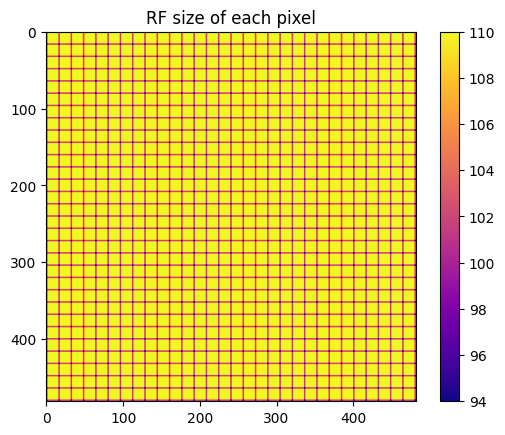

In [56]:
a = rf_small_rf_by_hparams[:, :, 1, 1] - rf_small_rf_by_hparams[:, :, 0, 1] + 1
b = rf_small_rf_by_hparams[:, :, 1, 0] - rf_small_rf_by_hparams[:, :, 0, 0] + 1
rf_sizes = np.sqrt(np.multiply(a, b))
plt.imshow(rf_sizes, cmap="plasma")
plt.colorbar()
plt.title("RF size of each pixel")
plt.show()

#### 1.5.3. Some TRFs of specific pixels

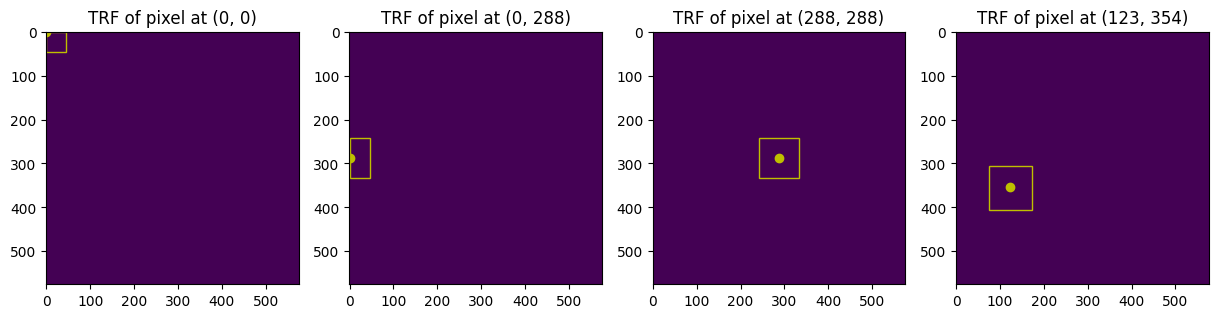

In [55]:
topleft_trf = model_small_rf_by_depth.pixel_trf(0, 0), (0,0)
topcenter_trf = model_small_rf_by_depth.pixel_trf(0, 576//2), (0, 576//2)
center_trf = model_small_rf_by_depth.pixel_trf(576//2, 576//2), (576//2, 576//2)
other_trf = model_small_rf_by_depth.pixel_trf(123, 354), (123, 354)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i, (trf, pos) in enumerate([topleft_trf, topcenter_trf, center_trf, other_trf]):
    axs[i].imshow(np.zeros((576, 576)))
    axs[i].plot(pos[0], pos[1], 'yo')
    axs[i].set_title(f"TRF of pixel at {pos}")
    start = trf[0, 0], trf[0, 1]
    len_x = trf[1, 0] - trf[0, 0] + 1
    len_y = trf[1, 1] - trf[0, 1] + 1
    patch = patches.Rectangle(start, len_x, len_y, linewidth=1, edgecolor='y', facecolor='none')
    axs[i].add_patch(patch)

plt.show()

#### 1.4.4. Training results
These are the loss plots of the two training sets when training for 100 epochs.
I found experimentally that a batch size of 2 and starting learning rate of 0.01 are optimal for both datasets.

In [ ]:
display(Image(filename='results/small_rf_by_hparams/fetal_head.png'))
display(Image(filename='results/small_rf_by_hparams/breast_cancer.png'))

#### 1.4.5. Test results

In [ ]:
# TODO